In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pickle
import time
from tqdm.notebook import tqdm

import torch
torch.set_default_tensor_type(torch.DoubleTensor)

from spatial_scene_grammars.nodes import *
from spatial_scene_grammars.rules import *
from spatial_scene_grammars.scene_grammar import *
from spatial_scene_grammars.visualization import *
from spatial_scene_grammars_examples.dish_bin.grammar import *
from spatial_scene_grammars.parsing import *
from spatial_scene_grammars.sampling import *
from spatial_scene_grammars.parameter_estimation import *
from spatial_scene_grammars.dataset import *
from spatial_scene_grammars.torch_utils import calculate_mmd

from utils import get_observed_node_sets

import meshcat
import meshcat.geometry as meshcat_geom

Generating from folder  sink/plates_cups_and_bowls/plates
sink:plates_cups_and_bowls:plates:Threshold_Bistro_Ceramic_Dinner_Plate_Ruby_Ring :  <class 'spatial_scene_grammars_examples.dish_bin.grammar.sink:plates_cups_and_bowls:plates:Threshold_Bistro_Ceramic_Dinner_Plate_Ruby_Ring'>
sink:plates_cups_and_bowls:plates:Ecoforms_Plate_S20Avocado :  <class 'spatial_scene_grammars_examples.dish_bin.grammar.sink:plates_cups_and_bowls:plates:Ecoforms_Plate_S20Avocado'>
sink:plates_cups_and_bowls:plates:Room_Essentials_Salad_Plate_Turquoise :  <class 'spatial_scene_grammars_examples.dish_bin.grammar.sink:plates_cups_and_bowls:plates:Room_Essentials_Salad_Plate_Turquoise'>
Generating from folder  sink/plates_cups_and_bowls/cups
sink:plates_cups_and_bowls:cups:Cole_Hardware_Mug_Classic_Blue :  <class 'spatial_scene_grammars_examples.dish_bin.grammar.sink:plates_cups_and_bowls:cups:Cole_Hardware_Mug_Classic_Blue'>
sink:plates_cups_and_bowls:cups:Room_Essentials_Mug_White_Yellow :  <class 'spatial_

In [2]:
if 'vis' not in globals():
    vis = meshcat.Visualizer()
vis.delete()
base_url = "http://127.0.0.1"
meshcat_url = base_url + ":" + vis.url().split(":")[-1]
print("Meshcat url: ", meshcat_url)
'''
from IPython.display import HTML
HTML("""
    <div style="height: 400px; width: 100%; overflow-x: auto; overflow-y: hidden; resize: both">
    <iframe src="{url}" style="width: 100%; height: 100%; border: none"></iframe>
</div>
""".format(url=meshcat_url))
'''

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7005/static/
Meshcat url:  http://127.0.0.1:7005/static/


'\nfrom IPython.display import HTML\nHTML("""\n    <div style="height: 400px; width: 100%; overflow-x: auto; overflow-y: hidden; resize: both">\n    <iframe src="{url}" style="width: 100%; height: 100%; border: none"></iframe>\n</div>\n""".format(url=meshcat_url))\n'

In [3]:
# Load in datasets.
observed_node_sets, observed_node_sets_outliers = get_observed_node_sets(reconvert=True)
# One of the 10-element appears to be breaking the multiprocessing stuff,
# so I need to cut them out for now...
observed_node_sets = [o for o in observed_node_sets if len(o) <= 9]
print(len(observed_node_sets), " inlier examples and ", len(observed_node_sets_outliers), " outlier examples")

68  inlier examples and  3  outlier examples


In [4]:
total_of_each_type = {"DishBin": 0}
for model_type_set in [PlateModels, CupModels, BowlModels]:
    for model_type in model_type_set:
        total_of_each_type[model_type.__name__] = 0
for observed_nodes in observed_node_sets:
    for node in observed_nodes:
        total_of_each_type[type(node).__name__] += 1
print(total_of_each_type)

{'DishBin': 68, 'sink:plates_cups_and_bowls:plates:Threshold_Bistro_Ceramic_Dinner_Plate_Ruby_Ring': 34, 'sink:plates_cups_and_bowls:plates:Ecoforms_Plate_S20Avocado': 26, 'sink:plates_cups_and_bowls:plates:Room_Essentials_Salad_Plate_Turquoise': 44, 'sink:plates_cups_and_bowls:cups:Cole_Hardware_Mug_Classic_Blue': 29, 'sink:plates_cups_and_bowls:cups:Room_Essentials_Mug_White_Yellow': 39, 'sink:plates_cups_and_bowls:cups:Threshold_Porcelain_Coffee_Mug_All_Over_Bead_White': 33, 'sink:plates_cups_and_bowls:bowls:Bradshaw_International_11642_7_Qt_MP_Plastic_Bowl': 27, 'sink:plates_cups_and_bowls:bowls:Cole_Hardware_Bowl_Scirocco_YellowBlue': 31, 'sink:plates_cups_and_bowls:bowls:Room_Essentials_Bowl_Turquiose': 31}


In [5]:
# Draw a random sample from the grammar with its initial params and visualize it.
#torch.random.manual_seed(5)
pyro.set_rng_seed(42)
grammar = SpatialSceneGrammar(
    root_node_type = DishBin,
    root_node_tf = drake_tf_to_torch_tf(RigidTransform(p=[0.5, 0., 0.]))
)
supertree = grammar.make_super_tree(max_recursion_depth=10)
print("Supertree size ", len(supertree.nodes))

sampled_tree = grammar.sample_tree(detach=True)
observed_nodes = sampled_tree.get_observed_nodes()

vis["initial_sample"].delete()
draw_scene_tree_contents_meshcat(sampled_tree, zmq_url=vis.window.zmq_url, prefix="initial_sample/contents")
draw_scene_tree_structure_meshcat(sampled_tree, zmq_url=vis.window.zmq_url, prefix="initial_sample/structure", node_sphere_size=0.01)

[2022-01-11 20:27:47.655] [console] [warning] FindResource ignoring DRAKE_RESOURCE_ROOT='/home/gizatt/drake' because it does not contain a 'drake' subdirectory.


Supertree size  571


In [6]:
# Parse that dummy observation; it should have only one unique parse, since there's only one
# object. Use no pose proposals, as this grammar is pure-dependency.
trees = infer_mle_tree_with_mip_from_proposals(
    grammar, observed_nodes, {}, verbose=1, N_solutions=5, max_recursion_depth=10
)
vis["sampled_scene_parse"].delete()
draw_scene_tree_contents_meshcat(trees[0], zmq_url=vis.window.zmq_url, prefix="sampled_scene_parse/contents")
for k, tree in enumerate(trees[:3]):
    draw_scene_tree_structure_meshcat(tree, zmq_url=vis.window.zmq_url, prefix="sampled_scene_parse/structure/%d" % k, node_sphere_size=0.01)

Optimization success?:  True
Logfile: 

Gurobi 9.0.2 (linux64) logging started Tue Jan 11 20:27:48 2022

Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (linux64)
Optimize a model with 1985 rows, 699 columns and 4607 nonzeros
Model fingerprint: 0xc252ebd7
Variable types: 0 continuous, 699 integer (699 binary)
Coefficient statistics:
  Matrix range     [5e-01, 1e+00]
  Objective range  [5e-01, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-01, 1e+00]
Presolve removed 1985 rows and 699 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.00 seconds
Thread count was 1 (of 12 available processors)

Solution count 1: 4.06044 

Optimal solution found (tolerance 1.00e-03)
Best objective 4.060443570577e+00, best bound 4.060443570577e+00, gap 0.0000%

Building tree for sol 0...


In [7]:
# Check we recover the GT parse tree for that  random scene.
print("Best parse score: ", trees[0].score(include_continuous=True))
print("GT tree score: ", sampled_tree.score(include_continuous=True))
deviations = []
for node in trees[0]:
    R = node.rotation.detach().numpy()
    deviations.append(np.sum(R.T.dot(R) - np.eye(3)))
print("Max deviation: ", np.max(np.abs(deviations)))

Best parse score:  tensor([-4.0604])
GT tree score:  tensor([-4.0604])
Max deviation:  1.0386656812411132e-15


# Approximate EM parameter fitting with IP parser

In [8]:
em = EMWrapper(grammar, observed_node_sets, parsing_strategy="ip_noproposals", do_nlp_refinement=False)
em.do_iterated_em_fitting(em_iterations=30, tqdm=tqdm, N_solutions=10, num_workers=10, max_recursion_depth=10)

EM Iteration:   0%|          | 0/30 [00:00<?, ?it/s]

Chunk 1/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 2/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 3/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 4/4:   0%|          | 0/8 [00:00<?, ?it/s]

Chunk 1/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 2/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 3/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 4/4:   0%|          | 0/8 [00:00<?, ?it/s]

Chunk 1/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 2/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 3/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 4/4:   0%|          | 0/8 [00:00<?, ?it/s]

Chunk 1/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 2/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 3/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 4/4:   0%|          | 0/8 [00:00<?, ?it/s]

Chunk 1/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 2/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 3/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 4/4:   0%|          | 0/8 [00:00<?, ?it/s]

Chunk 1/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 2/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 3/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 4/4:   0%|          | 0/8 [00:00<?, ?it/s]

Chunk 1/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 2/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 3/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 4/4:   0%|          | 0/8 [00:00<?, ?it/s]

Chunk 1/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 2/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 3/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 4/4:   0%|          | 0/8 [00:00<?, ?it/s]

Chunk 1/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 2/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 3/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 4/4:   0%|          | 0/8 [00:00<?, ?it/s]

Chunk 1/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 2/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 3/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 4/4:   0%|          | 0/8 [00:00<?, ?it/s]

Chunk 1/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 2/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 3/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 4/4:   0%|          | 0/8 [00:00<?, ?it/s]

Chunk 1/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 2/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 3/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 4/4:   0%|          | 0/8 [00:00<?, ?it/s]

Chunk 1/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 2/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 3/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 4/4:   0%|          | 0/8 [00:00<?, ?it/s]

Chunk 1/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 2/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 3/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 4/4:   0%|          | 0/8 [00:00<?, ?it/s]

Chunk 1/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 2/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 3/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 4/4:   0%|          | 0/8 [00:00<?, ?it/s]

Chunk 1/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 2/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 3/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 4/4:   0%|          | 0/8 [00:00<?, ?it/s]

Chunk 1/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 2/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 3/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 4/4:   0%|          | 0/8 [00:00<?, ?it/s]

Chunk 1/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 2/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 3/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 4/4:   0%|          | 0/8 [00:00<?, ?it/s]

Chunk 1/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 2/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 3/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 4/4:   0%|          | 0/8 [00:00<?, ?it/s]

Chunk 1/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 2/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 3/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 4/4:   0%|          | 0/8 [00:00<?, ?it/s]

Chunk 1/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 2/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 3/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 4/4:   0%|          | 0/8 [00:00<?, ?it/s]

Chunk 1/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 2/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 3/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 4/4:   0%|          | 0/8 [00:00<?, ?it/s]

Chunk 1/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 2/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 3/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 4/4:   0%|          | 0/8 [00:00<?, ?it/s]

Chunk 1/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 2/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 3/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 4/4:   0%|          | 0/8 [00:00<?, ?it/s]

Chunk 1/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 2/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 3/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 4/4:   0%|          | 0/8 [00:00<?, ?it/s]

Chunk 1/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 2/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 3/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 4/4:   0%|          | 0/8 [00:00<?, ?it/s]

Chunk 1/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 2/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 3/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 4/4:   0%|          | 0/8 [00:00<?, ?it/s]

Chunk 1/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 2/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 3/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 4/4:   0%|          | 0/8 [00:00<?, ?it/s]

Chunk 1/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 2/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 3/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 4/4:   0%|          | 0/8 [00:00<?, ?it/s]

Chunk 1/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 2/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 3/4:   0%|          | 0/20 [00:00<?, ?it/s]

Chunk 4/4:   0%|          | 0/8 [00:00<?, ?it/s]

SpatialSceneGrammar(
  (params_by_node_type): ModuleDict(
    (sink:plates_cups_and_bowls:plates:Threshold_Bistro_Ceramic_Dinner_Plate_Ruby_Ring): None
    (sink:plates_cups_and_bowls:plates:Room_Essentials_Salad_Plate_Turquoise): None
    (TerminalObject): ConstrainedParameter()
    (Plate): None
    (TerminalCup): ConstrainedParameter()
    (ObjectsOnPlate): ConstrainedParameter()
    (sink:plates_cups_and_bowls:cups:Threshold_Porcelain_Coffee_Mug_All_Over_Bead_White): None
    (TerminalBowl): ConstrainedParameter()
    (DishBin): ConstrainedParameter()
    (sink:plates_cups_and_bowls:cups:Room_Essentials_Mug_White_Yellow): None
    (sink:plates_cups_and_bowls:plates:Ecoforms_Plate_S20Avocado): None
    (sink:plates_cups_and_bowls:bowls:Room_Essentials_Bowl_Turquiose): None
    (Object): ConstrainedParameter()
    (sink:plates_cups_and_bowls:cups:Cole_Hardware_Mug_Classic_Blue): None
    (sink:plates_cups_and_bowls:bowls:Cole_Hardware_Bowl_Scirocco_YellowBlue): None
    (Bowl): None


In [9]:
# Save our grammar params
torch.save(grammar.state_dict(), "fit_grammar.torch")
with open("fit_em.pickle", "wb") as fp:
    pickle.dump(em, fp)

# Plotting and inspection of EM fitting process

In [10]:
with open("fit_em.pickle", "rb") as fp:
    em = pickle.load(fp)
assert len(em.grammar_iters) > 0

Text(0.5, 1.0, 'Fitting progress curve')

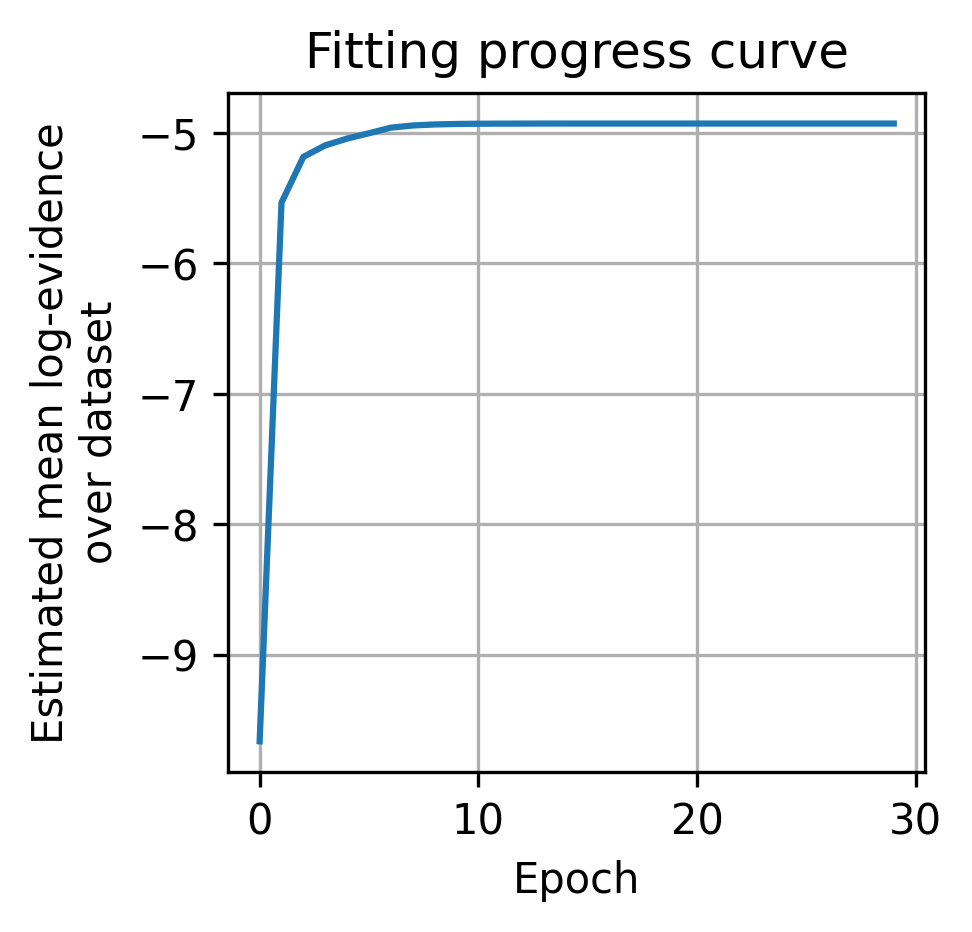

In [37]:
plt.figure(dpi=300).set_size_inches(3, 3)
plt.plot([np.mean(x) for x in em.log_evidence_iters])
plt.xlabel("Epoch")
plt.grid()
plt.ylabel("Estimated mean log-evidence\nover dataset")
plt.title("Fitting progress curve")

In [32]:
# For each step over the fitting process, draw a population of samples from the
# candidate grammar, and collect the population of each terminal object type. Calculate
# MMDs against the corresponding populations of observed object types in the dataset.

# Precompute populations for dataset, and the dictionary we'll use to
# store the distance measurements.
observed_population_by_type = {}
for observed_nodes in observed_node_sets:
    for observed_node in observed_nodes:
        key = type(observed_node).__name__
        if key not in observed_population_by_type.keys():
            observed_population_by_type[key] = []
        observed_population_by_type[key].append(observed_node.tf)
for key, value in observed_population_by_type.items():
    observed_population_by_type[key] = torch.stack(value)

mmds_by_type = {key: [] for key in observed_population_by_type.keys()}

# For each EM iteration...
N_samples = 1000
mmd_alphas = [0.01, 0.05, 0.1, 0.5, 1.]
for k, grammar_state_dict in tqdm(enumerate(em.grammar_iters), total=len(em.grammar_iters)):
    grammar.load_state_dict(grammar_state_dict)
    # Build a population of observed nodes.
    sampled_population_by_type = {key: [] for key in observed_population_by_type.keys()}
    for k in range(N_samples):
        observed_nodes = grammar.sample_tree(detach=True).get_observed_nodes()
        for observed_node in observed_nodes:
            key = type(observed_node).__name__
            if key not in sampled_population_by_type:
                logging.warning("Sampled object not in observations: %s" % key)
                sampled_population_by_type[key] = []
            sampled_population_by_type[key].append(observed_node.tf)
    for key, value in sampled_population_by_type.items():
        sampled_population_by_type[key] = torch.stack(value)
    # Compute MMDs
    for key in observed_population_by_type.keys():
        observed_pop = observed_population_by_type[key]
        sampled_pop = sampled_population_by_type[key]
        if observed_pop.shape[0] > 0 and sampled_pop.shape[0] > 0:
            mmds_by_type[key].append(
                calculate_mmd(observed_pop, sampled_pop, alphas=mmd_alphas, use_se3_metric=True)
            )
        else:
            logging.warning("%d observed, %d sampled, can't compare." % (observed_pop.shape[0], sampled_pop.shape[0]))
            mmds_by_type[key].append(np.inf)

  0%|          | 0/31 [00:00<?, ?it/s]

Initial: 0.219695 +/- 0.175030
Final: 0.070471 +/- 0.082722


[Text(0, 0, '0'),
 Text(1, 0, '1'),
 Text(2, 0, '2'),
 Text(3, 0, '5'),
 Text(4, 0, '10'),
 Text(5, 0, '30')]

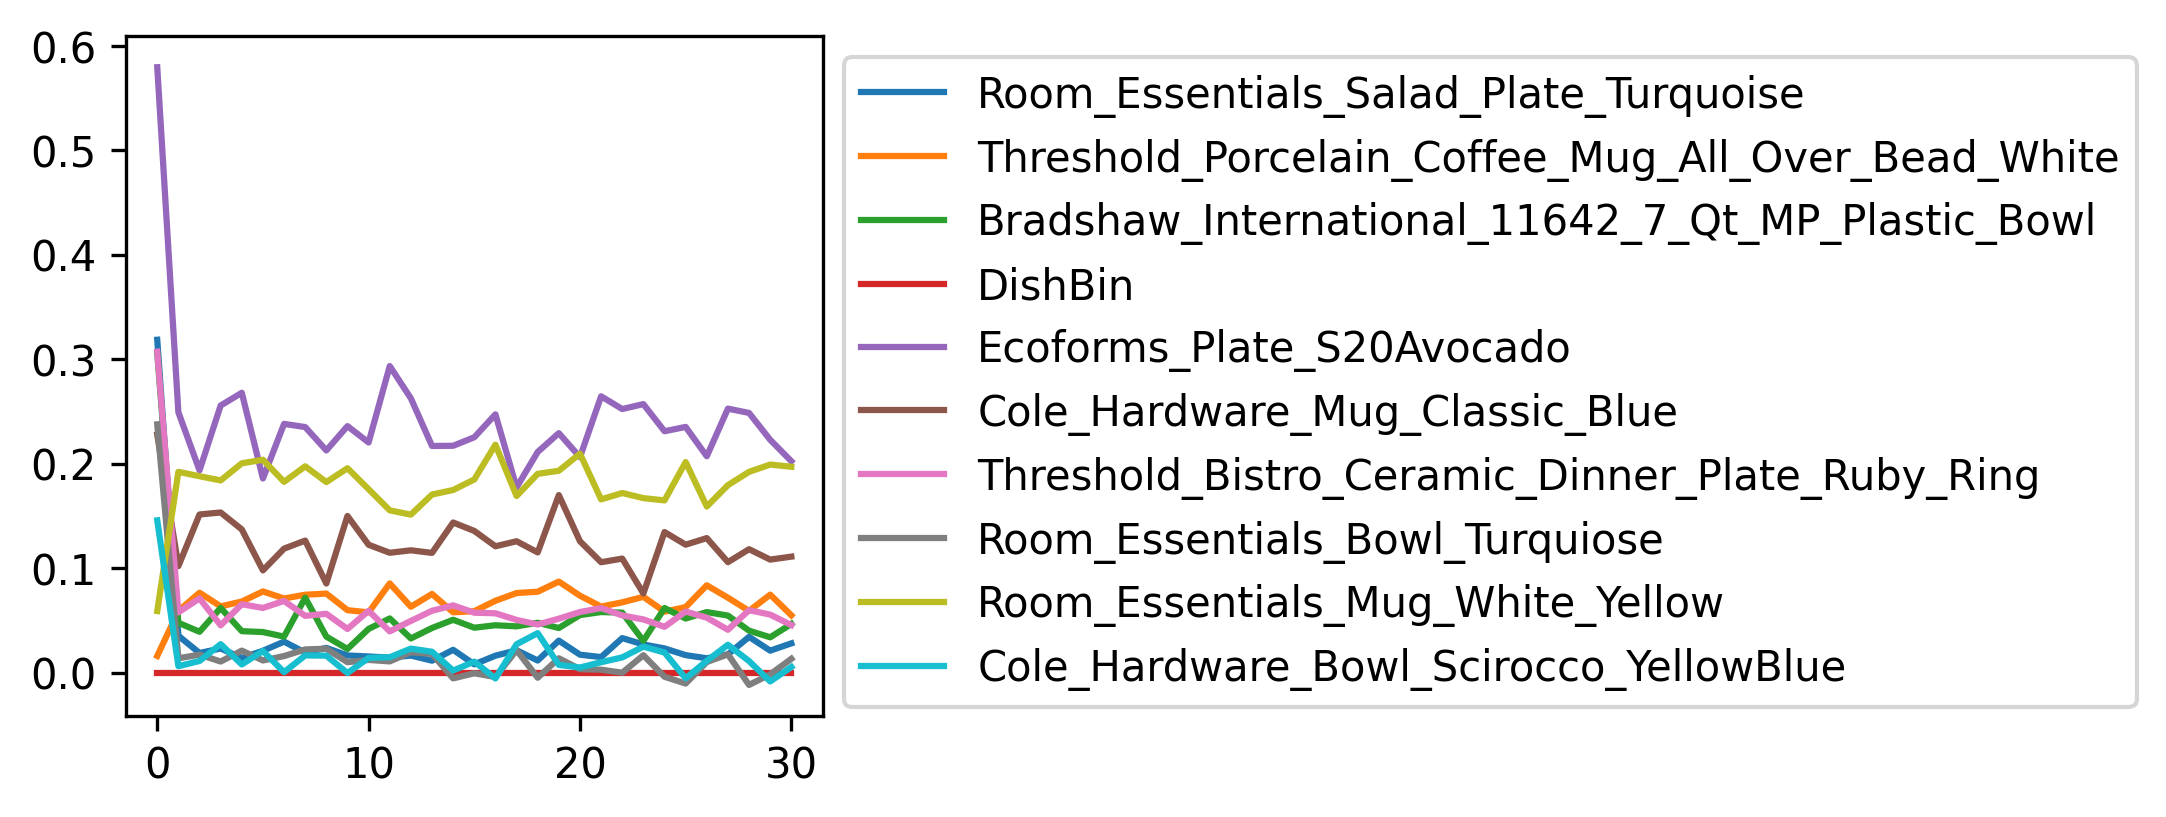

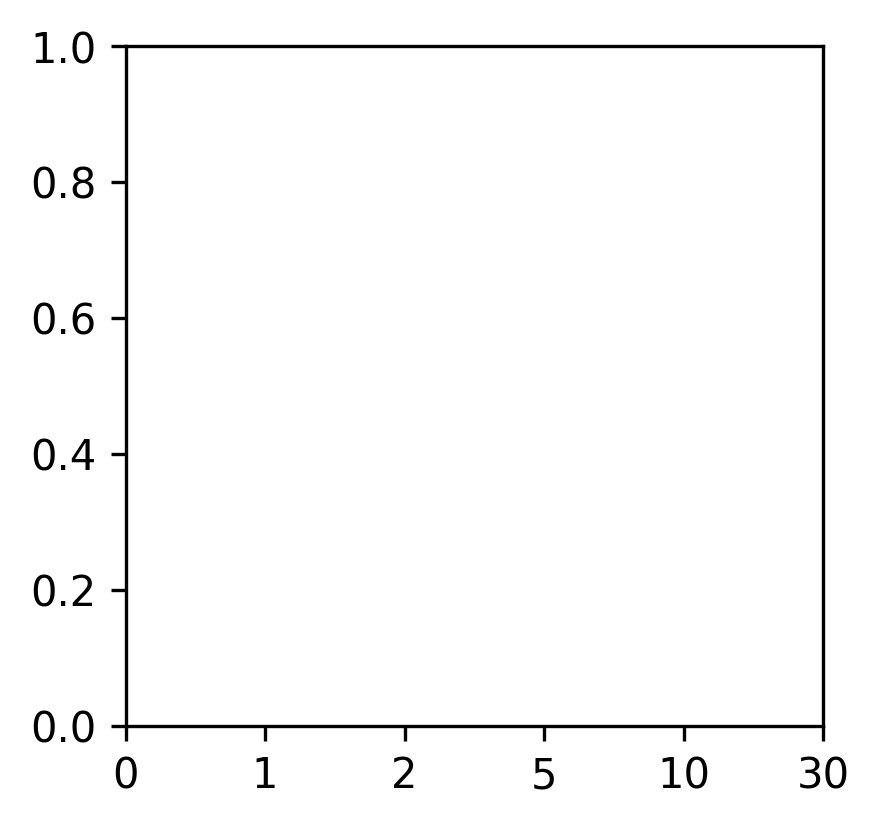

In [33]:
# Plot all of those over time.
plt.figure(dpi=300).set_size_inches(3, 3)

for key, value in mmds_by_type.items():
    plt.plot(value, label=key.split(":")[-1])

plt.legend(bbox_to_anchor=(1, 1))

initial_mmds = torch.tensor([v[0] for v in mmds_by_type.values()])
last_mmds = torch.tensor([v[-2] for v in mmds_by_type.values()])
print("Initial: %f +/- %f" % (torch.mean(initial_mmds), torch.std(initial_mmds)))
print("Final: %f +/- %f" % (torch.mean(last_mmds), torch.std(last_mmds)))

plt.figure(dpi=300).set_size_inches(3, 3)
probe_points = [0, 1, 2, 5, 10, 30]
plt.gca().set_xticks(range(len(probe_points)))
plt.gca().set_xticklabels(probe_points)


DishBin : 
Final params:  tensor([2.2251e-308,  1.7311e-01,  1.8593e-01,  4.0614e-01,  1.6001e-01,
         3.1018e-02,  4.3794e-02])
mean tensor([[ 0.0000,  0.0000,  0.1000],
        [-0.0065,  0.0299,  0.0593],
        [-0.0083,  0.0336,  0.0581],
        [-0.0087,  0.0334,  0.0586],
        [-0.0090,  0.0336,  0.0591],
        [-0.0094,  0.0343,  0.0594],
        [-0.0098,  0.0349,  0.0595],
        [-0.0099,  0.0355,  0.0596],
        [-0.0099,  0.0358,  0.0596],
        [-0.0099,  0.0360,  0.0596],
        [-0.0099,  0.0361,  0.0597],
        [-0.0099,  0.0362,  0.0597],
        [-0.0099,  0.0362,  0.0597],
        [-0.0099,  0.0363,  0.0597],
        [-0.0099,  0.0363,  0.0597],
        [-0.0099,  0.0363,  0.0597],
        [-0.0099,  0.0363,  0.0597],
        [-0.0099,  0.0363,  0.0597],
        [-0.0099,  0.0363,  0.0598],
        [-0.0099,  0.0363,  0.0598],
        [-0.0099,  0.0363,  0.0598],
        [-0.0099,  0.0363,  0.0598],
        [-0.0099,  0.0363,  0.0598],
        [-

Bowl : 


TerminalBowl : 
Final params:  tensor([0.3034, 0.3483, 0.3483])
ObjectsInBowl : 
Final params:  tensor([2.9738e-01, 5.1370e-01, 1.8891e-01, 8.6653e-24])
mean tensor([[ 0.0000,  0.0000,  0.0500],
        [ 0.0055,  0.0005,  0.0554],
        [ 0.0058, -0.0033,  0.0647],
        [ 0.0055, -0.0032,  0.0679],
        [ 0.0056, -0.0029,  0.0691],
        [ 0.0057, -0.0028,  0.0695],
        [ 0.0058, -0.0029,  0.0696],
        [ 0.0059, -0.0029,  0.0693],
        [ 0.0059, -0.0029,  0.0691],
        [ 0.0059, -0.0029,  0.0688],
        [ 0.0059, -0.0029,  0.0687],
        [ 0.0059, -0.0029,  0.0686],
        [ 0.0059, -0.0029,  0.0685],
        [ 0.0059, -0.0029,  0.0684],
        [ 0.0059, -0.0029,  0.0684],
        [ 0.0059, -0.0028,  0.0684],
        [ 0.0059, -0.0028,  0.0684],
        [ 0.0059, -0.0028,  0.0684],
        [ 0.0059, -0.0028,  0.0684],
        [ 0.0059, -0.0028,  0.0684],
        [ 0.0059, -0.0028,  0.0684],
        [ 0.0060, -0.0028,  0.0684],
        [ 0.0060, -0.0028,  

TerminalObject : 
Final params:  tensor([0.4363, 0.3667, 0.1970])


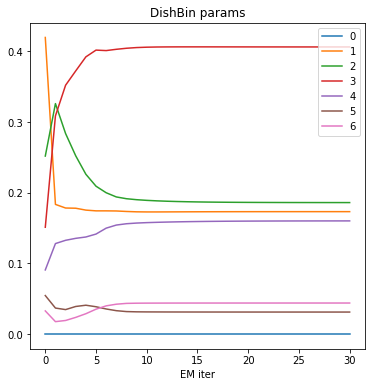

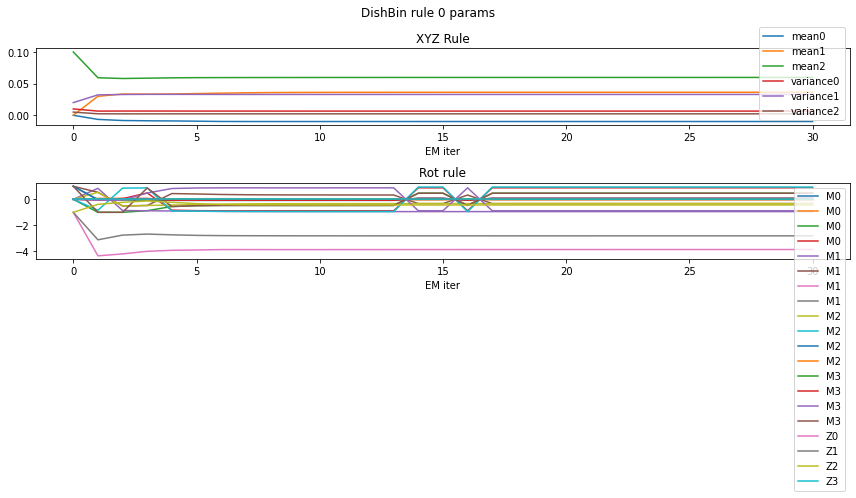

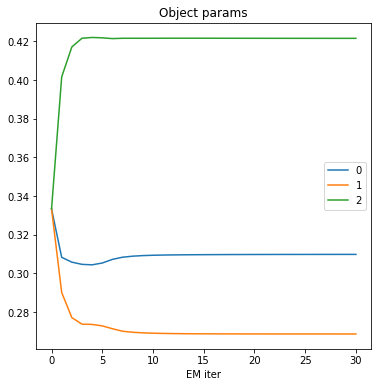

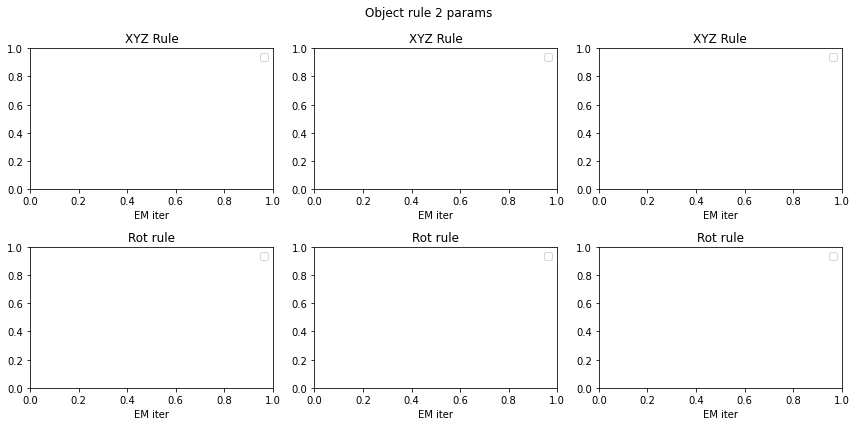

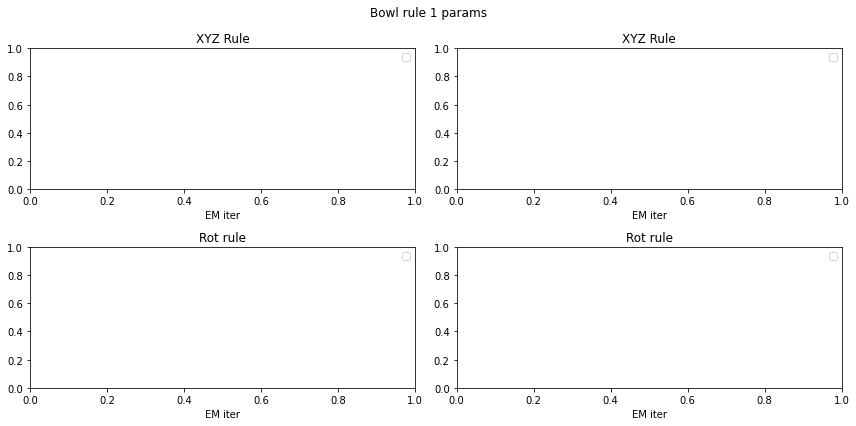

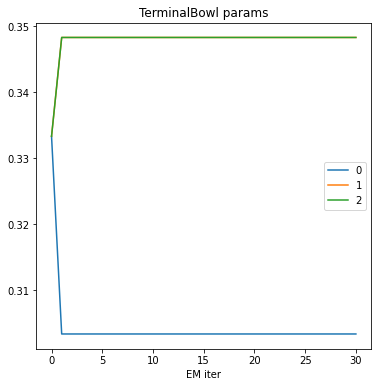

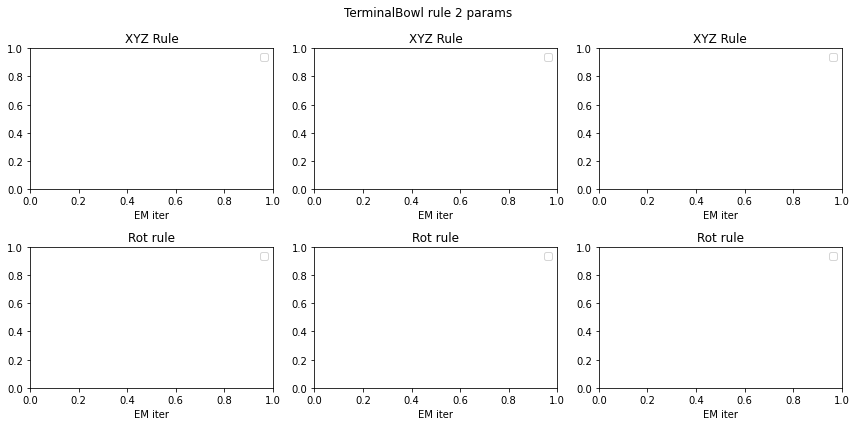

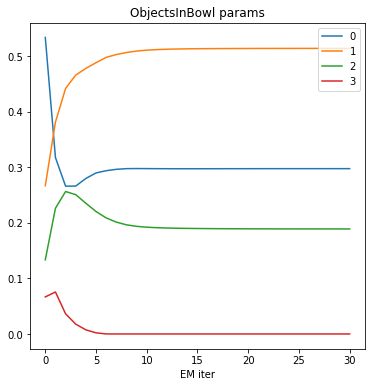

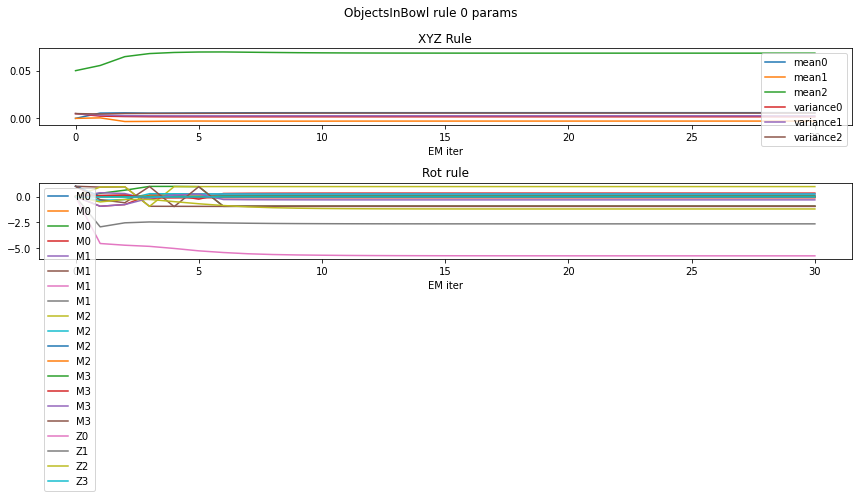

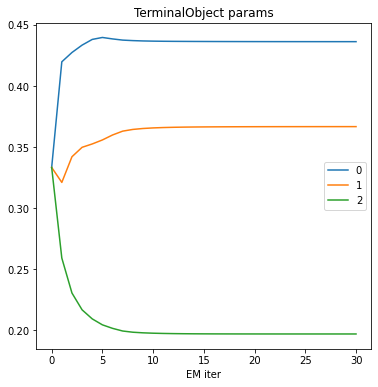

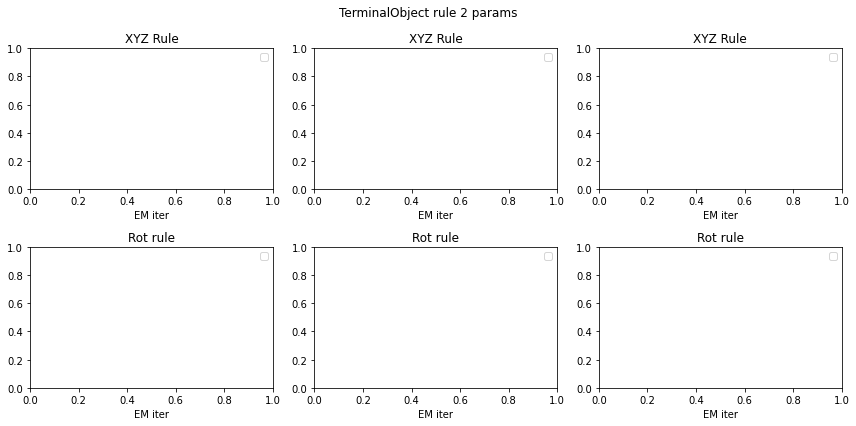

In [14]:
for node_type_to_plot in [DishBin, Object, Bowl, TerminalBowl, ObjectsInBowl, TerminalObject]:
    print(node_type_to_plot.__name__, ": ")
    em.plot_grammar_parameter_history(node_type_to_plot)

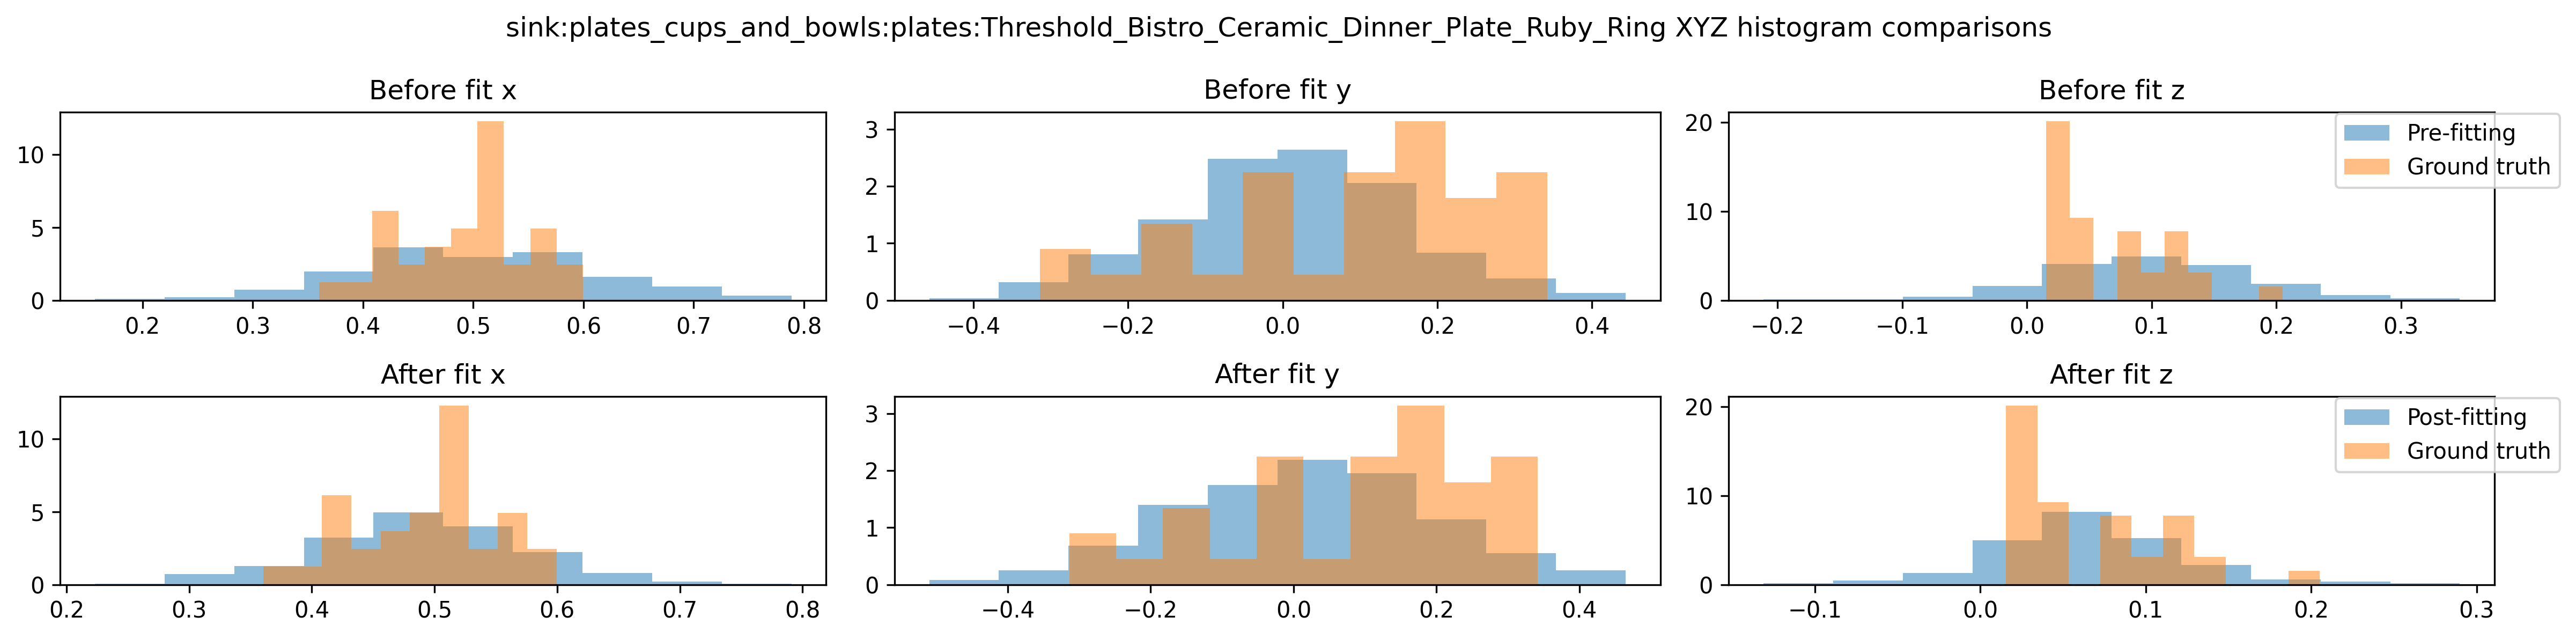

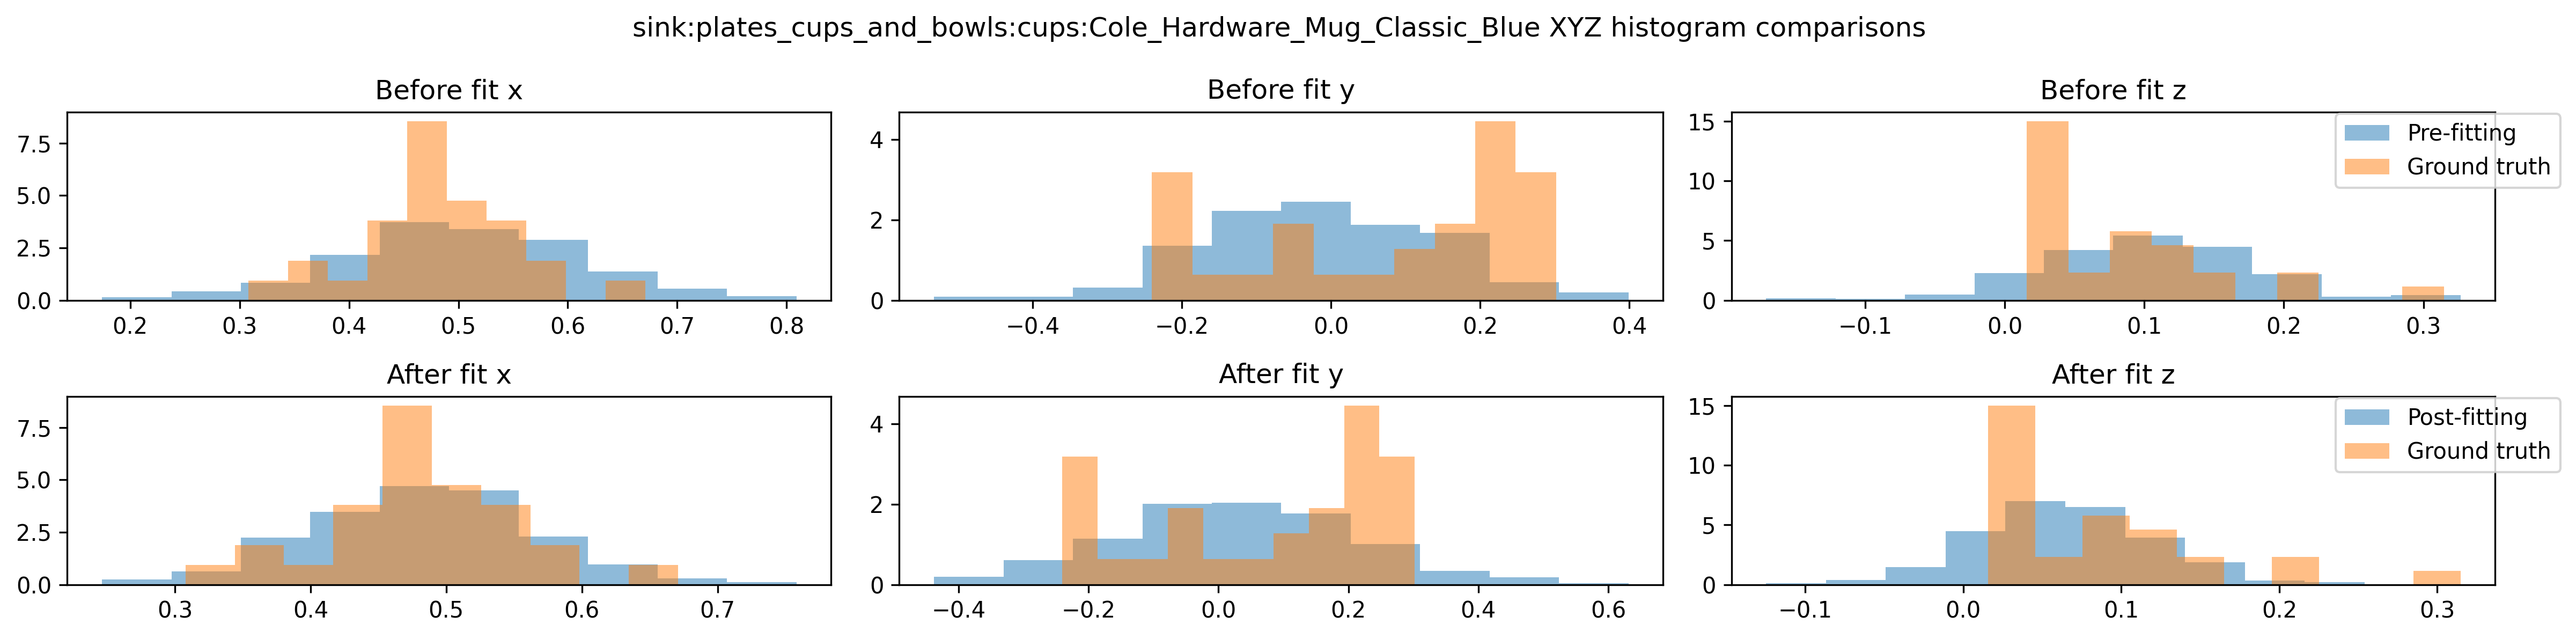

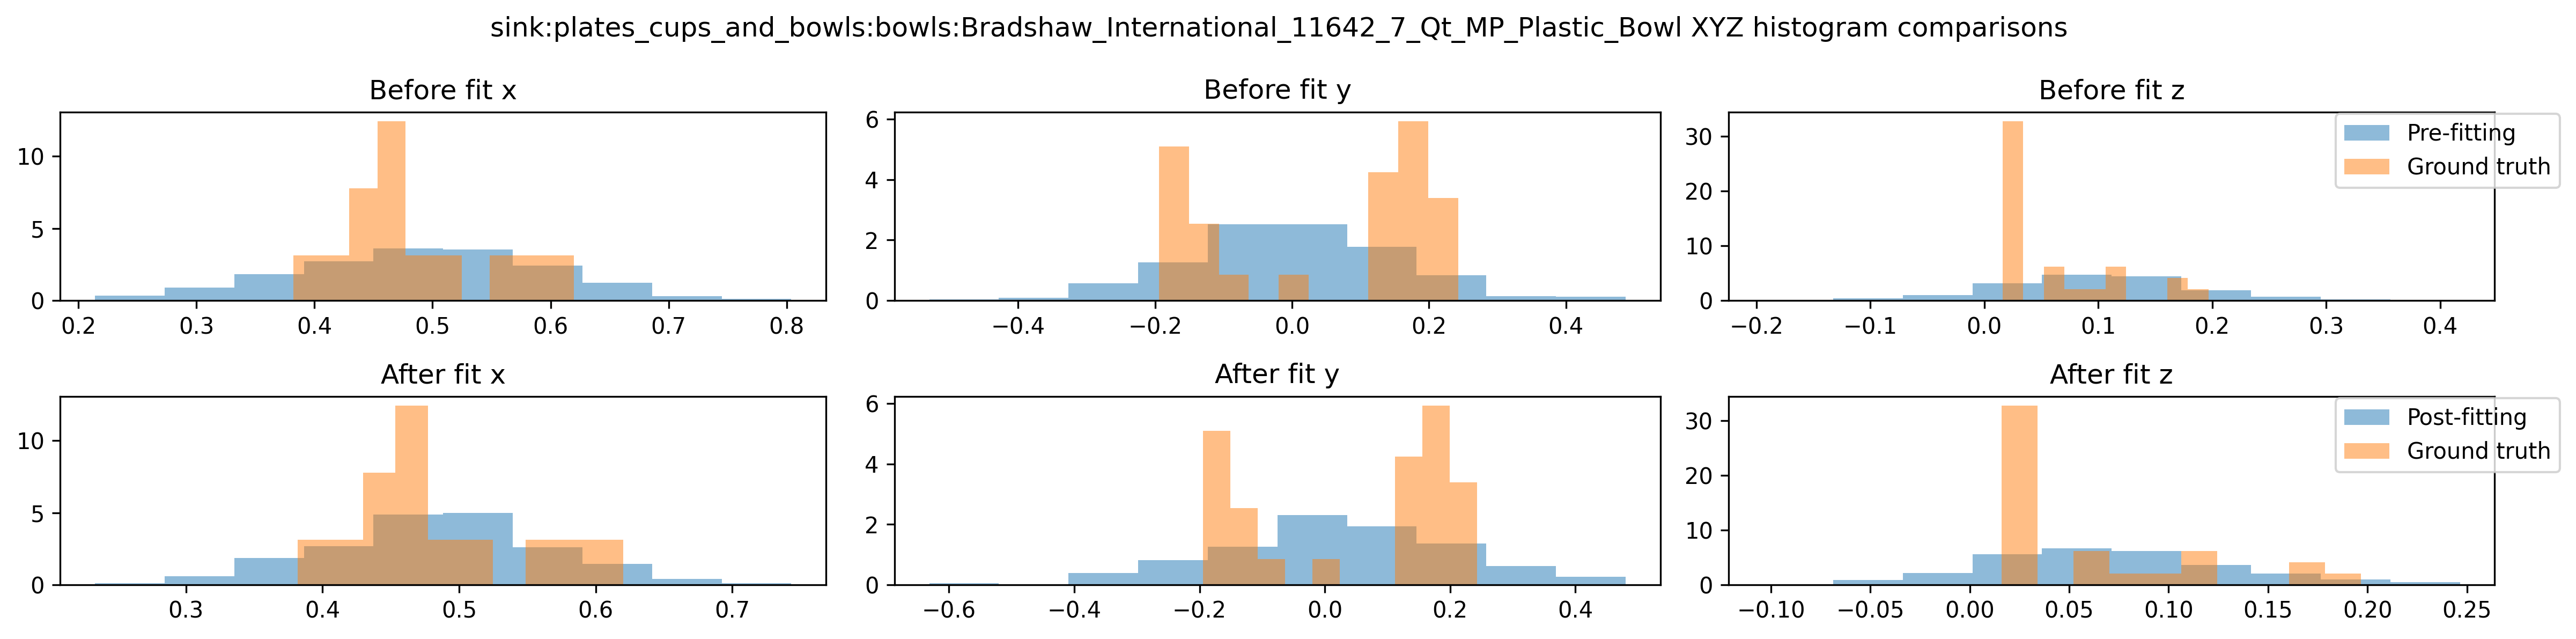

In [15]:
def get_all_node_xyzs(sampled_trees, node_type):
    l = []
    for tree in sampled_trees:
        for node in tree:
            if isinstance(node, node_type):
                l.append(node.translation.detach().cpu().numpy())
    return np.stack(l)
def plot_post_fit_tree_samples(em, N_samples=100):
    pre_fit_samples= []
    em.grammar.load_state_dict(em.grammar_iters[0])
    for k in range(N_samples):
        pre_fit_samples.append(em.grammar.sample_tree(detach=True))
    fit_samples = []
    em.grammar.load_state_dict(em.grammar_iters[-1])
    for k in range(N_samples):
        fit_samples.append(em.grammar.sample_tree(detach=True))

    for node_type in [PlateModels[0], CupModels[0], BowlModels[0]]:
        plt.figure(dpi=300).set_size_inches(16, 4)
        plt.suptitle("%s XYZ histogram comparisons" % node_type.__name__)

        gt_l = get_all_node_xyzs([SceneTree.make_from_observed_nodes(sample) for sample in observed_node_sets], node_type)
        fit_l = get_all_node_xyzs([sample for sample in fit_samples], node_type)
        pre_fit_l = get_all_node_xyzs([sample for sample in pre_fit_samples], node_type)
        # Pre fit
        for k in range(3):
            plt.subplot(2, 3, k+1)
            plt.title("Before fit %s" % "xyz"[k:(k+1)])
            plt.hist(pre_fit_l[:, k], label="Pre-fitting", alpha=0.5, density=True)
            plt.hist(gt_l[:, k], label="Ground truth", alpha=0.5, density=True)
            if k == 2:
                plt.legend(bbox_to_anchor=(1.1, 1.05))

        for k in range(3):
            plt.subplot(2, 3, k+1+3)
            plt.title("After fit %s" % "xyz"[k:(k+1)])
            plt.hist(fit_l[:, k], label="Post-fitting", alpha=0.5, density=True)
            plt.hist(gt_l[:, k], label="Ground truth", alpha=0.5, density=True)
            if k == 2:
                plt.legend(bbox_to_anchor=(1.1, 1.05))
        plt.tight_layout()
plot_post_fit_tree_samples(em, N_samples=1000)

In [16]:
# Draw some samples from the fit posterior
vis["fit_samples"].delete()
for k in range(5):
    tree = grammar.sample_tree(detach=True)
    draw_scene_tree_contents_meshcat(tree, zmq_url=vis.window.zmq_url, prefix="fit_samples/%d/contents" % k)
    draw_scene_tree_structure_meshcat(tree, zmq_url=vis.window.zmq_url, prefix="fit_samples/%d/structure" % k)

# Test parsing a scene

In [ ]:
# Set up grammar
grammar = SpatialSceneGrammar(
    root_node_type = DishBin,
    root_node_tf = drake_tf_to_torch_tf(RigidTransform(p=[0.5, 0., 0.]))
)
grammar.load_state_dict(torch.load("fit_grammar.torch"))

In [ ]:
# Parse that dummy observation; it should have only one unique parse, since there's only one
# object.
results = infer_mle_tree_with_mip(grammar, observed_node_sets[8], N_solutions=1, max_recursion_depth=10, verbose=True)
trees = get_optimized_trees_from_mip_results(results)
vis["parses"].delete()
for k, tree in enumerate(trees[:1]):
    if k == 0:
        draw_scene_tree_contents_meshcat(tree, zmq_url=vis.window.zmq_url, prefix="parses/contents/%d" % k)
    draw_scene_tree_structure_meshcat(tree, zmq_url=vis.window.zmq_url, prefix="parses/structure/%d" % k, alpha=0.25, node_sphere_size=0.01)
    print("Computed score %f, optimization score %f" % (tree.score(verbose=0), results.optim_result.get_suboptimal_objective(k)))

In [ ]:
# Parse all scenes in dataset, and return by best score.
# Parse that dummy observation; it should have only one unique parse, since there's only one
# object.

with open("observed_outlier_node_sets.dat", "rb") as f:
    observed_node_sets_outliers = pickle.load(f)
    
parses = get_map_trees_for_observed_node_sets(grammar, observed_node_sets, N_solutions=1, num_workers=10, tqdm=tqdm)
parses = [parse[0] for parse in parses]
scores = torch.stack([parse.score() for parse in parses]).detach().numpy()

parses_outliers = get_map_trees_for_observed_node_sets(grammar, observed_node_sets_outliers, N_solutions=1, num_workers=10, tqdm=tqdm)
parses_outliers = [parse[0] for parse in parses_outliers]
scores_outliers = torch.stack([parse.score() for parse in parses_outliers]).detach().numpy()

In [ ]:
inds_ascending = np.argsort(scores, axis=0)
print("Ranking: ", inds_ascending)
plt.hist(scores, bins=100, label="Training set")
plt.hist(scores_outliers, bins=100, label="Outliers")
plt.xlabel("Log-prob of best parse tree")
plt.ylabel("Occurance in dataset")
plt.legend()
print(parses[-1].score(verbose=True))